# Satellite data (part 2)
----
J. Potemra
April 2022

----

# Outline
In this notebook we will look at a variety of satellite data and apply these data to different questions.  We will first start with sea level as measured by altimetry and do some comparisons to tide gauge data.  Next, we'll have a look at surface temperature and try do some trend analysis.  After that, we'll have a look at scatterometer winds and compute Ekman currents.  Finally, we'll have a look at ocean ocean.

# 1. Satellite data: Sea level

In this exercise we will try to access and plot satellite-derived data.  To make things even more flexible, we will read data from remote data services (_i.e._, there will be no need to access data on the SOEST disks or download anything to your local machine).  As mentioned before, NASA PO.DAAC, the APDRC and PacIOOS are all good places to look for data:

 * https://thredds.jpl.nasa.gov/thredds/catalog.html
 * http://apdrc.soest.hawaii.edu/data/data.php
 * https://pacioos.org/thredds

Additionally, we will make use of the mapping functions within cartopy.  This is just one way to draw coastlines; GeoPandas and matplotlib are two others.

As usual, the first thing we want to do is import all the necessary packages:
<ul>
    <li> Numpy for numerical analysis and array handling
    <li> Matplotlib, pyplot for plots
    <li> cartopy for coastlines
    <li> netCDF4 to read the data from remote (OPeNDAP) servers (recall xarray is another way to do this)
</ul>

In [1]:
# load array utils
import numpy as np

# load in plotting rountines
import matplotlib.pyplot as plt
# this for colormaps
from matplotlib import cm

# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netcdf for working with OPeNDAP files
import netCDF4 as nc

# import pandas for data handling and dates
import pandas as pd

# import datetime for date handling
import datetime as dt

## 1A. Plot map of sea level from AVISO at particular time
In this first example we'll try make a plot of sea level anomalies from satellite altimeter, specifically the AVISO product.  We can get the proper URL from the JPL PO.DAAC server.

In [2]:
# specify the URL to the data set, then create data object
URL = 'https://thredds.jpl.nasa.gov/thredds/dodsC/ncml_aggregation/SeaSurfaceTopography/aviso/dynamic_topo_1deg_1mo/zos_AVISO_L4_199210-201012.nc'
file = nc.Dataset(URL)

In [3]:
# We can optionally print out the variables and metadata in the file
print(file.variables)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    bounds: time_bnds
    units: days since 1950-01-01 00:00:00
    calendar: standard
    axis: T
    long_name: time
    standard_name: time
unlimited dimensions: time
current shape = (219,)
filling off, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (219, 2)
filling off, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    bounds: lat_bnds
    units: degrees_north
    axis: Y
    long_name: latitude
    standard_name: latitude
unlimited dimensions: 
current shape = (180,)
filling off, 'lat_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 lat_bnds(lat, bnds)
unlimited dimensions: 
current shape = (180, 2)
filling off, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    bounds: lon_bnds
    units: degrees_east
    axis: X
    long_name: longitude
    standard_name: longitude
unlimited dimensions: 
current shape = (360,)
fil

In [6]:
# Next, as an example, let's extract data for a specific time, e.g.,
# extract lat, lon, and sea level anomaly at time=1
sat_lat  = file.variables['lat'][:]
sat_lon  = file.variables['lon'][:]
sat_time = file.variables['time'][:]
sat_sea_level = file.variables['zos'][1,:,:]

# NOTE: it's usually good practice to "close" the file after done
#   extracting.  To do this:
#file.close()
#   but we will be needing this later, so I'll leave this commented out.

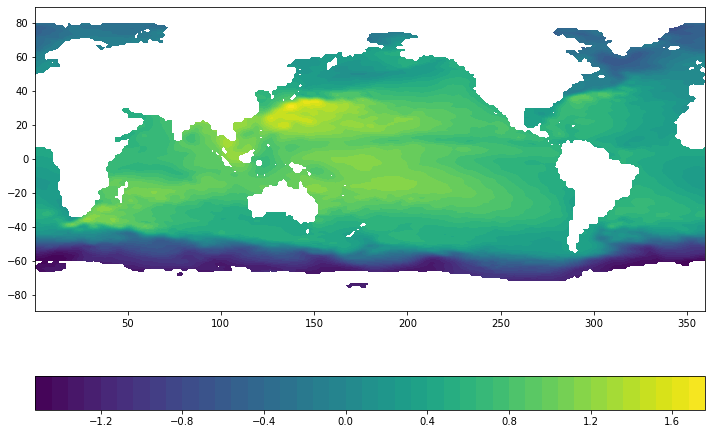

In [5]:
# Now let's make a quick plot to see what we have
fig=plt.figure( figsize = (12, 8) )
plt.contourf(sat_lon, sat_lat, sat_sea_level, 50)
plt.colorbar(orientation='horizontal');

### Side note about time

In this example, we arbitrarily choose time index 1 (_i.e._, the SECOND time-step).  How can we determine what date this corresponds to?  And, maybe we want to select a different time, but not on index but on date.  How can we do this?

It turns out the file does have metadata that tells us how the time (number) corresponds to a date.  We can use this, and the datetime function to convert.

In [8]:
# first, let's have a look at the units on the variable time:

print(file.variables['time'].units)

days since 1950-01-01 00:00:00


In [10]:
# and what are the first and last values, difference between 
#   successive times, and how many are there?
print("the first time is ", sat_time[0])
print("the last time is ", sat_time[-1])
print("the range is ", sat_time[-1]-sat_time[0]+1)
print("number of times ", len(sat_time))
#print(sat_time[0],sat_time[-1],sat_time[1]-sat_time[0],len(sat_time))

the first time is  15629.5
the last time is  22264.5
the range is  6636.0
number of times  219


In [11]:
# okay, time is a number from 15,629.5 to 22,264.5 
#   that represents "days since Jan 1, 1950 at 00:00:00",
#   there are 219 of them, and they appear to be monthly
# how to convert to a date?
#   the netCDF4 package has a "num2date" method, and this
#   requires a variable name and unit; we can use this,
#   then make a date with Pandas datetime like before (!)

time_convert = nc.num2date(file.variables['time'],
                           file.variables['time'].units,
                           only_use_cftime_datetimes=False)
date = pd.to_datetime(time_convert)

In [12]:
print(date)

DatetimeIndex(['1992-10-16 12:00:00', '1992-11-16 00:00:00',
               '1992-12-16 12:00:00', '1993-01-16 12:00:00',
               '1993-02-15 00:00:00', '1993-03-16 12:00:00',
               '1993-04-16 00:00:00', '1993-05-16 12:00:00',
               '1993-06-16 00:00:00', '1993-07-16 12:00:00',
               ...
               '2010-03-16 12:00:00', '2010-04-16 00:00:00',
               '2010-05-16 12:00:00', '2010-06-16 00:00:00',
               '2010-07-16 12:00:00', '2010-08-16 12:00:00',
               '2010-09-16 00:00:00', '2010-10-16 12:00:00',
               '2010-11-16 00:00:00', '2010-12-16 12:00:00'],
              dtype='datetime64[ns]', length=219, freq=None)


In [16]:
# We now have a "proper" date, how can we search?
#  use the "get_loc" method on our date

print(date.get_loc('1997-12-15'))
print(date[62])

slice(62, 62, None)
1997-12-16 12:00:00


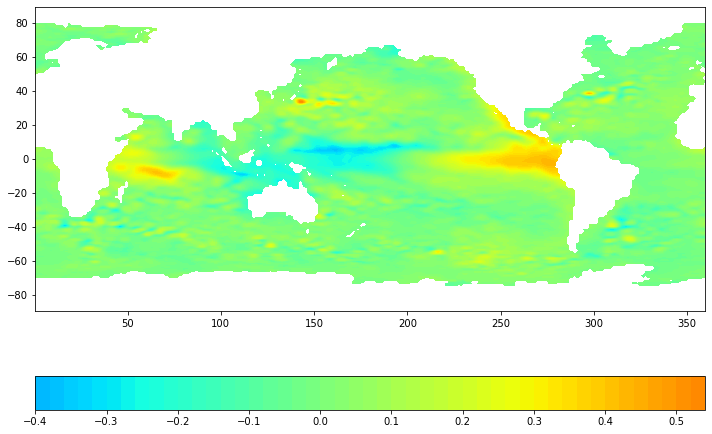

In [17]:
# okay, now let's redo our plot, but now select the 63rd time-step
# that corresponds to December 1997:
sat_sea_level1 = file.variables['zos'][51,:,:]
sat_sea_level2 = file.variables['zos'][62,:,:]
fig=plt.figure( figsize = (12, 8) )
levels = np.linspace(-1.4,1.4,51)
plt.contourf(sat_lon, sat_lat, sat_sea_level2-sat_sea_level1, 
             50, vmin = -1.0, vmax = 1.0, cmap = cm.jet)
plt.colorbar(orientation='horizontal')

Now let's copy/paste the map drawing code from last time and polish up the plot

/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


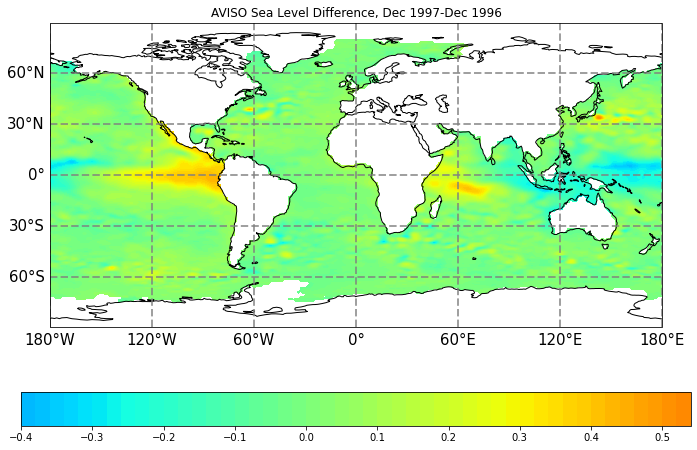

In [18]:
# draw color-shaded plot with map background

# set up the figure
fig=plt.figure( figsize = (12, 8) )

# set projection
ax = plt.axes(projection = ccrs.PlateCarree())

# color-shade sea level ('data') on same projection
plt.contourf(sat_lon, sat_lat, sat_sea_level2-sat_sea_level1, 50,
             vmin=-1.0,vmax=1.0, cmap=cm.jet, transform=ccrs.PlateCarree())

# add coastlines
ax.add_feature(cf.COASTLINE)

# add lat/lon labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Add a colorbar and title
plt.colorbar(orientation='horizontal')
plt.title('AVISO Sea Level Difference, Dec 1997-Dec 1996');

## 1B. Make a time-series at a point

Now, let's try and extract a point near Hawaii (roughly 22N, 158W) and plot vs. all time.  Note since we closed the data set, we need to re-open and extract like last time.

In [19]:
# This time let's use the APDRC file, first we "close" the last one
file.close()

URL = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/satellite_product/TOPEX/AVISO_reference/msla_monthly'
file = nc.Dataset(URL)
sat_time = file.variables['time'][:]
sat_lat  = file.variables['lat'][:]
sat_lon  = file.variables['lon'][:]

In [24]:
# We now look for "where" the salellite data set has a measurement near 22N, 158W;
#  note that we don't know the exact resolution of the satellite data set, 
#  so we search within a range.  For example, the satellite may not have data
#  at 21.75, and if we search for lat = 21.75 we'd get nothing back.  On the other
#  hand, if our search is too wide, we may end up with more that one point.
# To do the search, we use the numpy "argwhere" method

# step one, find the index corresponding to our point
J = np.argwhere((sat_lat > 21.5) & (sat_lat < 22.0))
I = np.argwhere((sat_lon > 202) & (sat_lon < 202.5))
print(I,J)

# step two, extract the data at this I,J index
sealevel_hnl_aviso = file.variables['sla'][:,int(I),int(J)]

[[607]] [[524]]


In [25]:
sealevel_hnl_aviso.shape

(208,)

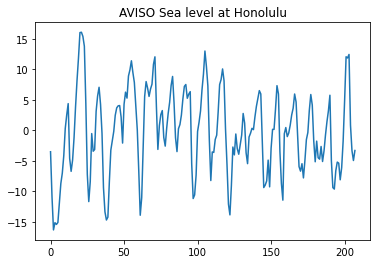

In [26]:
# Make a plot
plt.plot(sealevel_hnl_aviso)
plt.title('AVISO Sea level at Honolulu');

Note that the x-axis is just sequential from 1 to 208, corresponding to the array index (row) of the dataset.  But what we really want is time.  Checking the metadata (see above; time.units) you can see the time values are monthly mean values from December 1992 and are reported in "days since 1-1-1".  This is a standard, but bad, reference used for example in matlab.  It cannot directly convert in python, _e.g._, this will give an error:

    time_convert = nc.num2date(time)
    date = pd.to_datetime(time_convert)
    
So, we'll have to add an extra step.  There are probably many ways to do this, but here let's just use the fact that we know the data start on Dec 15, 1992.  If we subtrac this from all the subsequent days, we have re-referenced the time value to "days since Dec 15, 1992".  In other words:

    date = time - time[0]

will have time as "days since Jan 1, 0001" and date as "days since Dec 15, 1992".  We can then pass this to datetime.

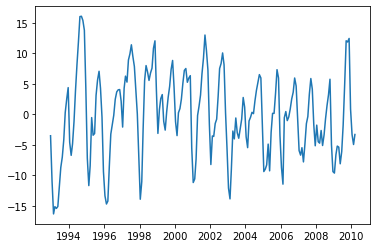

In [27]:
date_aviso = pd.to_datetime(sat_time-sat_time[0], 
                unit='D', origin = pd.Timestamp('1992-12-15 00:00:00'))
plt.plot(date_aviso,sealevel_hnl_aviso);

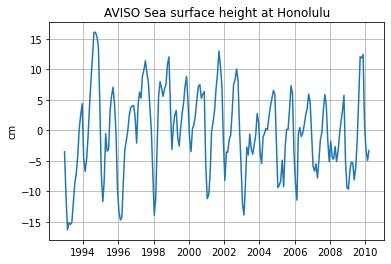

In [28]:
# Now plot with date as the x-axis (and add a grid and title)
plt.plot(date_aviso,sealevel_hnl_aviso)
plt.grid()
plt.title('AVISO Sea surface height at Honolulu')
plt.ylabel('cm');

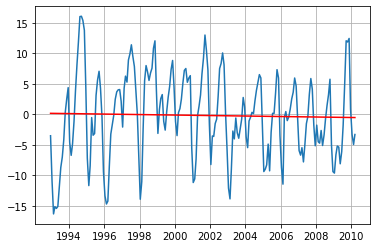

In [29]:
# next step is to fit a line, just line we did with the tide gauges
t = np.arange(0,len(sat_time))
B = np.polyfit(t,sealevel_hnl_aviso,1)
# convert trend in cm/month to cm/decade
trend = B[0]  * 12.0 * 10.0
# cheap way to round to two digits
trend = int(trend*100.0)/100.0
Y = np.polyval(B,t)
plt.plot(date_aviso,sealevel_hnl_aviso)
plt.plot(date_aviso,Y,'r')
plt.grid();

## 1C. Compare to tide gauge data

In [30]:
URL = 'http://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h057.csv'
column_headings = ['year', 'month', 'day', 'hour', 'sealevel_hnl_tideg']
hnl_data = pd.read_csv(URL,names=column_headings)

hnl_data[hnl_data['sealevel_hnl_tideg'] < 0] = np.nan
hnl_data['date_tideg'] = pd.to_datetime(hnl_data.index*3600.0, origin = '01-01-1905 10:00:00', unit='s')
hnl_data = hnl_data.set_index('date_tideg')
hnl_data['sealevel_hnl_tideg'] = ( hnl_data['sealevel_hnl_tideg'] - np.mean(hnl_data['sealevel_hnl_tideg']) ) / 10.0

(8401.0, 14974.0)

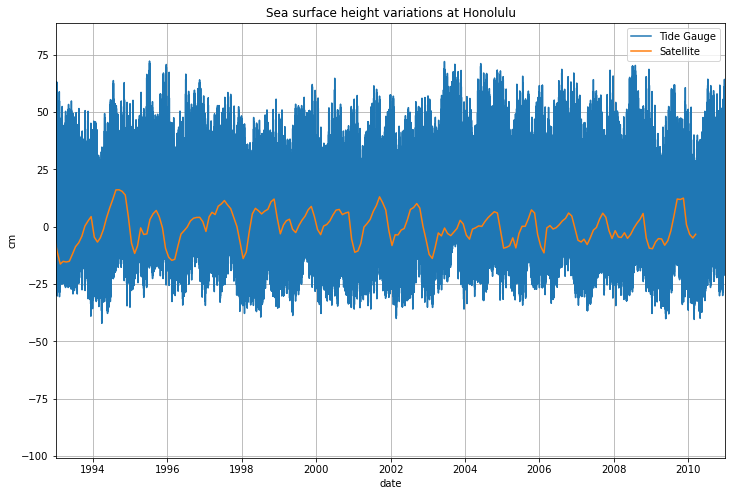

In [31]:
plt.figure(figsize=(12,8))
plt.plot(hnl_data['sealevel_hnl_tideg'],label='Tide Gauge')
plt.plot(date_aviso,sealevel_hnl_aviso,label='Satellite')
plt.title('Sea surface height variations at Honolulu')
plt.xlabel('date')
plt.ylabel('cm')
plt.grid()
plt.legend()
plt.xlim([dt.datetime(1993, 1, 1), dt.datetime(2010, 12, 31)])

In [32]:
type(hnl_data)

pandas.core.frame.DataFrame

In [33]:
hnl_data2 =  hnl_data.resample('M').mean()

(8401.0, 14974.0)

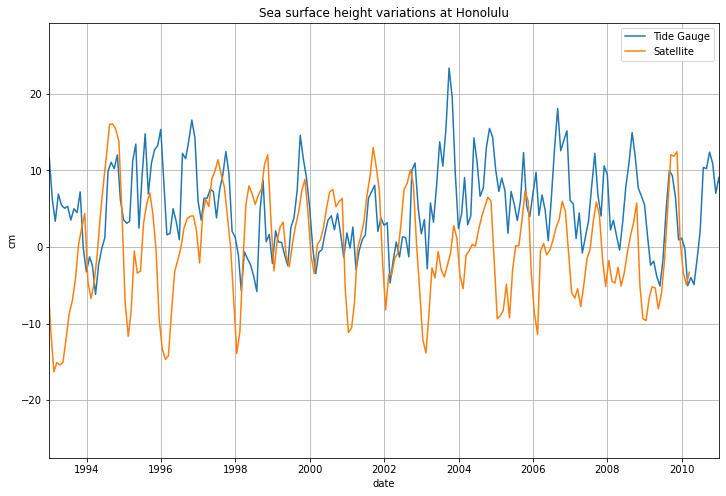

In [34]:
plt.figure(figsize=(12,8))
plt.plot(hnl_data2['sealevel_hnl_tideg'],label='Tide Gauge')
plt.plot(date_aviso,sealevel_hnl_aviso,label='Satellite')
plt.title('Sea surface height variations at Honolulu')
plt.xlabel('date')
plt.ylabel('cm')
plt.grid()
plt.legend()
plt.xlim([dt.datetime(1993, 1, 1), dt.datetime(2010, 12, 31)])

# 2. Satellite data: Sea surface temperature

In this exercise we will try to access and plot satellite-derived sea surface temperature (SST) and sea ice data.  Like last class, we will read data from remote data services.  Here we add a new one, a NOAA THREDDS server:

 * https://thredds.jpl.nasa.gov/thredds/catalog.html
 * http://apdrc.soest.hawaii.edu/data/data.php
 * https://pacioos.org/thredds 
 * https://psl.noaa.gov/thredds/aggregations.html

In [1]:
# load array utils
import numpy as np

# load in plotting rountines
import matplotlib.pyplot as plt
from matplotlib import cm

# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netcdf for working with OPeNDAP files
# (can also use xarray)
import netCDF4 as nc

# import pandas for data handling and dates
import pandas as pd

# import datetime for date handling
import datetime as dt

In [2]:
# Read data from NCDC THREDDS server: SST, SST anomales and ice concentrations
URL1 = 'https://psl.noaa.gov/thredds/dodsC/Aggregations/OISSThires/sst.mean.nc'
URL1a = 'https://psl.noaa.gov/thredds/dodsC/Aggregations/OISSThires/sst.anom.nc'
URL2 = 'https://psl.noaa.gov/thredds/dodsC/Aggregations/OISSThires/icec.mean.nc'

dataset1 = nc.Dataset(URL1)
dataset1a = nc.Dataset(URL1a)
dataset2 = nc.Dataset(URL2)

In [37]:
# Note that there is a variable called "time" and in this
#   the units are days since 1800-01-01 00:00:0
# We can convert this to datetime like last time

time_convert = nc.num2date(dataset1.variables['time'],dataset1.variables['time'].units,
                          only_use_cftime_datetimes=False)
date = pd.to_datetime(time_convert)

## 2A. Make lat/lon contour plots of SST and ice concentrations

Here we can pick a specific time, _e.g._, Feb 15, 2020, and just read that date.  Since the times were convered to datetime, this is straightforward:
          
    date = datetime(2020,3,15,0) 
    timeindex = date2index(date,timevar)
    
In this example, let's use the python indexing syntax of [-1] to get the last time available.  This is sometimes helpful when running a regular script (_e.g._, get the most recent file every day without knowing what that is
     
    timeindex = -1

In [38]:
# extract all lats, lons and variables for time at the last index
timeindex = -1
sst = dataset1.variables['sst'][timeindex,:]
sst_anom = dataset1a.variables['anom'][timeindex,:]
ice = dataset2.variables['icec'][timeindex,:]
lat = dataset1.variables['lat'][:]
lon = dataset1.variables['lon'][:]

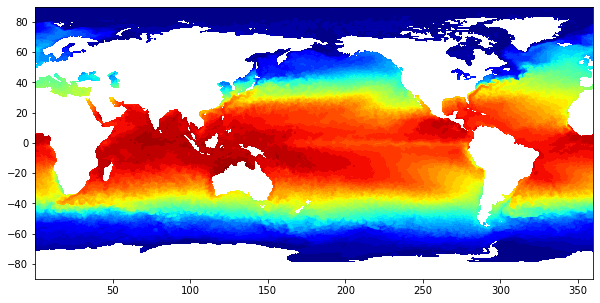

In [39]:
# make a quick plot
fig = plt.figure(figsize=(10, 5))
plt.contourf(lon,lat,sst,50,cmap=cm.jet);

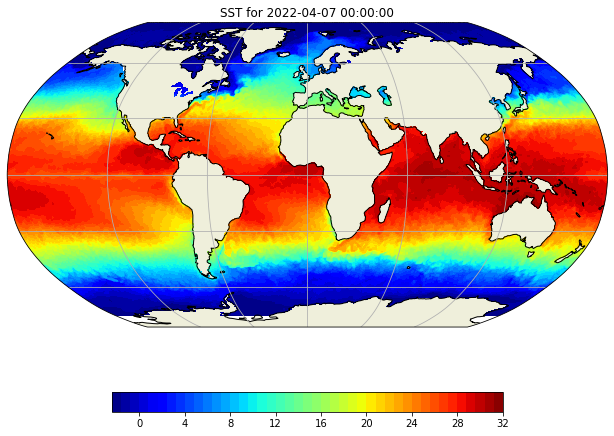

In [40]:
# make a much nicer plot

# set up the figure
fig=plt.figure( figsize = (14, 8) )

# set projection
# these work
ax = plt.axes(projection = ccrs.Robinson(central_longitude=0))
#ax = plt.axes(projection = ccrs.Mollweide(central_longitude=0))
#ax = plt.axes(projection = ccrs.Orthographic(central_longitude=0))
#ax = plt.axes(projection = ccrs.Orthographic(central_longitude=180))
#ax = plt.axes(projection = ccrs.NorthPolarStereo())
#ax.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())

# don't know why these do not
#ax = plt.axes(projection = ccrs.Robinson(central_longitude=180))
#ax = plt.axes(projection = ccrs.Mollweide(central_longitude=180))

# add grid lines, coastlines and color land values
ax.gridlines()
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAND)

# color-shade SST with 50 colors using the "jet" color scheme
# this works
plt.contourf(lon,lat,sst,50,transform=ccrs.PlateCarree(),cmap=cm.jet)

# these plot as rectangles
#plt.contourf(lon,lat,sst,50,transform=ccrs.Robinson(),cmap=cm.jet)
#plt.contourf(lon,lat,sst,50,cmap=cm.jet)

# draw title
ax.set_title('SST for %s'%date[-1])

# add colorbar
plt.colorbar(orientation='horizontal',shrink=0.5)

# sea ice
#plt.contourf(lon,lat,ice,4,transform=ccrs.PlateCarree(),cmap=cm.gist_gray);
#plt.colorbar(orientation='horizontal',shrink=0.3);

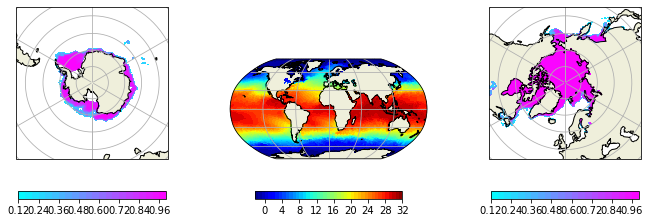

In [41]:
# Now make three plots, two polar plots and one global:
# colorbars at
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.figure(figsize=(12,4))

# first plot on the left: sea ice at the South Pole
ax1 = plt.subplot(1,3,1,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
ax1.add_feature(cf.COASTLINE)
ax1.add_feature(cf.LAND)
ax1.set_extent([-180, 180, -45, -90], ccrs.PlateCarree())
plt.contourf(lon,lat,ice,25,transform=ccrs.PlateCarree(),cmap=cm.cool)
plt.colorbar(orientation='horizontal',shrink=0.75)

# second plot in the middle; SST 
ax2 = plt.subplot(1,3,2,projection=ccrs.Robinson(central_longitude=0))
ax2.gridlines()
ax2.add_feature(cf.COASTLINE)
ax2.add_feature(cf.LAND)
plt.contourf(lon,lat,sst,50,transform=ccrs.PlateCarree(),cmap=cm.jet)
plt.colorbar(orientation='horizontal',shrink=0.75)

ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.gridlines()
ax3.add_feature(cf.COASTLINE)
ax3.add_feature(cf.LAND)
ax3.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())
plt.contourf(lon,lat,ice,25,transform=ccrs.PlateCarree(),cmap=cm.cool)
plt.colorbar(orientation='horizontal',shrink=0.75);

## 2B. Data at a point: computing the annual cycle

Like last lecture, we will extract a time-series at a particular point. You will notice in some places (like here in Hawaii), the seasonal cycle dominates the signal.  We usually want to remove that and look at "seasonal anomalies," and this means we first need to compute the mean seasonal cycle.  In some cases this gets tricky, _e.g._, with hourly data, irregularly spaced data and so on.

Pandas provides a nice way around this.

The data we've read in thus far are daily, over a long record.  This will still work, but may overload the server, so instead we'll read in a monthy mean product called "OISST", or "Optimally Interpolated Sea Surface Temperature".

Recall we have our old data sets still open, so it's good practice to first close these.

In [42]:
dataset1.close()
dataset1a.close()
dataset2.close()

In [43]:
# Open the new data set, monthly mean SST from NOAA
URL = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc'
file = nc.Dataset(URL)

# Extract lat/lon and time
lat = file.variables['lat'][:]
lon = file.variables['lon'][:]
time = file.variables['time'][:-1]

In [44]:
# like before, let's search for a point near Hawaii
# step one, find the index corresponding to our point
J = np.argwhere((lat > 21.0) & (lat < 22.0))
I = np.argwhere((lon > 201.0) & (lon < 202.5))

In [48]:
# extract SST at the specified point
# NOTE we want an even number of years, i.e., number of
# time points is multiple of 12
sst_HI = file.variables['sst'][2:-1,int(J),int(I)]

In [49]:
len(sst_HI)/12

40.0

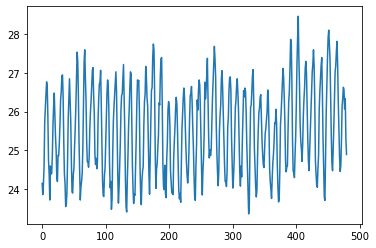

In [50]:
plt.plot(sst_HI);

In [51]:
# Again, like last time, convert the time variable to something more useful
time_convert = nc.num2date(file.variables['time'][2:-1],file.variables['time'].units,
                          only_use_cftime_datetimes=False)
date = pd.to_datetime(time_convert)

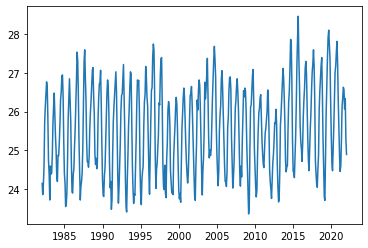

In [52]:
plt.plot(date,sst_HI)

We now wish to construct a monthly climatology, _i.e._, average January, average February, average March, _etc._  This would (and could) be done in a loop, and can get a little complicated.  This would be especially complex if we had daily data.  Pandas, however, has a nice method called "groupby" which will allow us to make a climatology quickly.  The steps are:
 1. put the SST date and data into a Pandas DataFrame
 2. compute the mean after grouping by month
 3. repeat the monthly means for the entire time record (_e.g._, if we have ten years of data, we'd repeat the mean seasonal cycle ten times)
 4. add the climatology to the DataFrame

In [53]:
# make dataframe
df = pd.DataFrame(sst_HI,date)
df.columns = ['SST']
print(df.head())

                  SST
1982-02-01  24.139999
1982-03-01  23.850000
1982-04-01  24.129999
1982-05-01  24.580000
1982-06-01  25.730000


In [54]:
# compute climatology: here we group the data by month, then compute the mean
mean_season = df.groupby(df.index.month).mean()

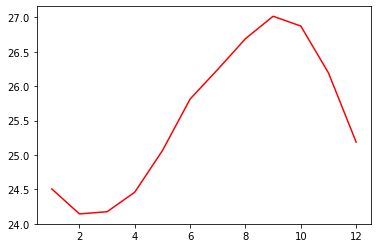

In [55]:
# we can now make a quick plot
plt.plot(mean_season,'r')

In [58]:
len(step3)

482

In [64]:
# Next, we want to add a second column to our DataFrame that
#  includes the mean seasonal cycle.  To do this we have to
#  repeat the 12-month variable "mean_season" over the entire
#  record.

# 1. collapse the variable to a single dimension
step1 = mean_season.squeeze()

# 2. repeat (tile) the data over all years
step2 = np.tile(step1, len(df)//len(mean_season))

# 3. pad the final rows (the above works on complete years,
#   and this data set has four extra months)
print(len(df)-len(step2))
step3 = np.append(step2,[mean_season.iloc[0],mean_season.iloc[1]])
print(len(step3))

# 4. finally, we add this to our DataFrame
df['mmean'] = step3[1:-1]

0
482


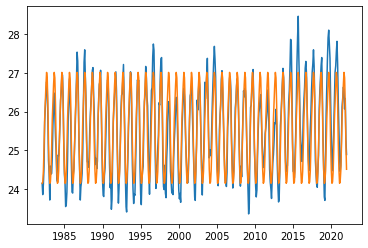

In [61]:
plt.plot(df)

Text(0.5, 1.0, 'SST Seasonal Anomalies near Hawaii')

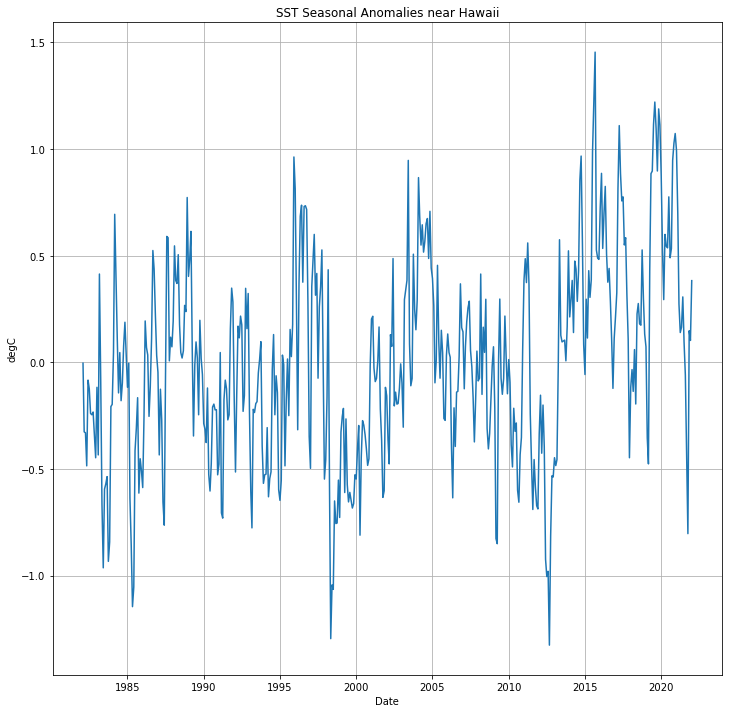

In [62]:
fig = plt.figure(figsize=(12,12))
plt.plot(date,df['SST']-df['mmean'])
plt.grid()
plt.xlabel('Date')
plt.ylabel('degC')
plt.title('SST Seasonal Anomalies near Hawaii')
#plt.xlim([dt.datetime(1981, 12, 1), dt.datetime(1982, 11, 30)])

0


Text(0.5, 1.0, 'SST Seasonal Anomalies near Galapagos')

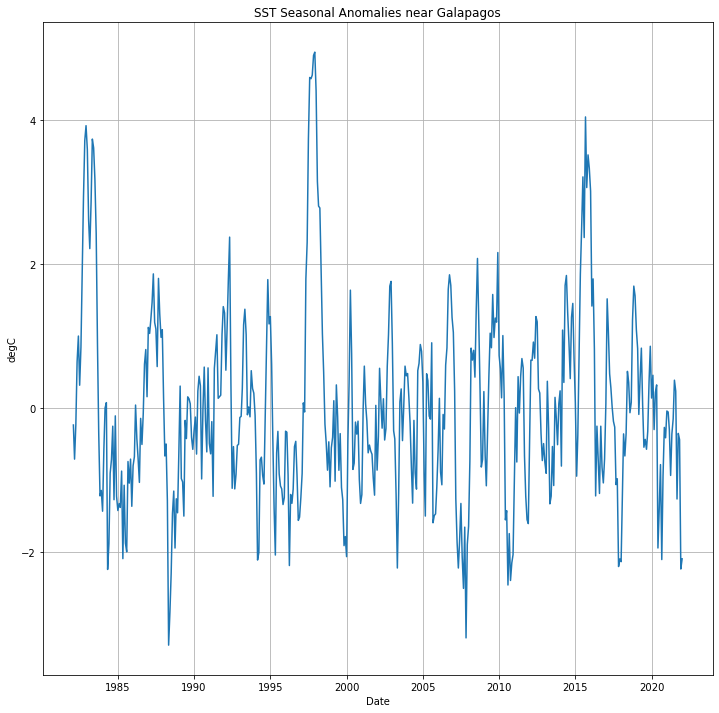

In [67]:
J = np.argwhere((lat > 0.0) & (lat < 1.0))
I = np.argwhere((lon > 260.0) & (lon < 261))
sst_GA = file.variables['sst'][2:-1,int(J),int(I)]
df2 = pd.DataFrame(sst_GA,date)
df2.columns = ['SST']
mean_season = df2.groupby(df2.index.month).mean()
step1 = mean_season.squeeze()
step2 = np.tile(step1, len(df2)//len(mean_season))
print(len(df2)-len(step2))
step3 = np.append(step2,[mean_season.iloc[0],mean_season.iloc[1]])
df2['mmean'] = step3[1:-1]

fig = plt.figure(figsize=(12,12))
plt.plot(date,df2['SST']-df2['mmean'])
plt.grid()
plt.xlabel('Date')
plt.ylabel('degC')
plt.title('SST Seasonal Anomalies near Galapagos')

# 3. Satellite winds: Ekman currents

Satellites can measure winds using a scatterometer, and this essentially measures the surface roughness, and from that winds can be derived.  Actually, this returns the _stress_ applied by the wind.  Wind stress is important as it drives ocean circulation.

The direct response of the ocean to winds is via [Ekman](https://en.wikipedia.org/wiki/Vagn_Walfrid_Ekman) currents.  The stress applied by the wind "pushes" the upper ocean, and Coriolis deflects the flow to the right in the Northern Hemisphere and to the left in the Southern Hemisphere.

In this notebook we will compute Ekman currents from surface winds.  Note that there are direct satellite measurements of stress, but as an exercise we'll start with speed.

We will use a blended NOAA/NCDC product from 
https://www.ncei.noaa.gov/thredds/blended-global/oceanWinds.html

__Background__
NOAA/NCDC Blended 6-hourly 0.25-degree Sea Surface Winds.  The data are created from multiple satellite observations: DMSP SSMI F08, F10, F11, F13, F14, F15; TMI; QuikSCAT; AMSR-E; Direction from NCEP Reanalysis-2

There is global ocean coverage with a 0.25-degree resolution. The whole datasets covers from July 1987 to present, 6-hourly resolution in this dataset; daily and monthly are also available in other directories. Include (u,v) means and scalar mean speed w for comparison.

Keywords: sea winds, ocean winds, sea surface winds, air-sea interaction, air-sea flux, wind-driven circulation, Ekman pumping, Ekman transport, ocean upwelling, wind stress, windstress

Reference links at http://www.ncdc.noaa.gov/oa/rsad/blendedseawinds.html

Simple spatiotemporally weighted Interpolation (SI), V.1.2. Version 1.2 uses updated satellite retrievals by Remote Sensing System, released in September 2006: SSMI V06, TMI V04, QSCAT V03a. AMSRE V05 was also updated using the new SSMI rain rate
institution: NOAA NESDIS National Climatic Data Center
Contact: Huai-Min.Zhang AT noaa.gov or satorder AT noaa.gov;         ph:1+828-271-4090
Acknowledgment: The gridded data were generated from the multiple satellite observations of DOD, NOAA and NASA (and future others) and wind retrievals of the Remote Sensing Systems, Inc. (http://www.remss.com), using scientific methods such as objective analysis (OA). The OA is only truly objective when the needed statistics are completely known, which may not be always the case.

Data_Calendar_Date: 2011-09-29

In [1]:
# load array utils
import numpy as np

# load in plotting rountines
import matplotlib.pyplot as plt
from matplotlib import cm

# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netcdf for working with OPeNDAP files
# (can also use xarray)
import netCDF4 as nc

# import pandas for data handling and dates
import pandas as pd

# import datetime for date handling
import datetime as dt

In [2]:
# here we use the monthly file since it has a little better coverage and it easier to load
url = 'https://www.ncei.noaa.gov/thredds/dodsC/uv/monthly_agg/Aggregation_of_Monthly_Ocean_Wind_best.ncd'
dataset = nc.Dataset(url)

In [3]:
# Like before, let's read data from a specific time, e.g.,
#  if timestep = 0, read the first time; timestep = -1,
#  read the last time
timestep = -1

# Extract the lat/lon/time arrays
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
time = dataset.variables['time'][:]

# Extract the zonal (u) and meridional (v) components of
#  wind speed. Note here that the data have an extra dimension, 
#  altitude, so we need to take that into account
uwind = dataset.variables['u'][timestep][0][:][:]
vwind = dataset.variables['v'][timestep][0][:][:]

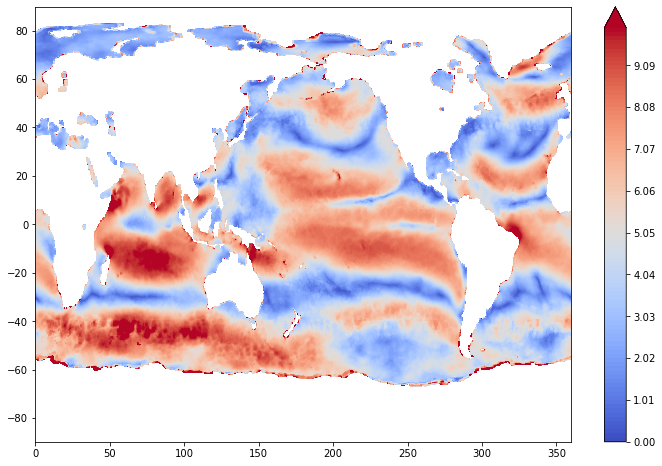

In [9]:
# make a quick plot of wind speed
plt.figure(figsize=(12,8))
#plt.contourf(lon,lat,np.sqrt(uwind*uwind+vwind*vwind), cmap = cm.jet)
#plt.colorbar();

#plt.contourf(lon,lat,np.sqrt(uwind*uwind+vwind*vwind), 
#             vmin = 0.0, vmax = 10.0, cmap = cm.jet)
#plt.colorbar();

levels = np.linspace(0.0, 10.0, 100)
CS = plt.contourf(lon,lat,np.sqrt(uwind*uwind+vwind*vwind),
                  levels = levels, cmap=cm.coolwarm, extend='max')
plt.colorbar(CS);

## 3A. Compute Ekman flow

The first step in calculating the Ekman currents is obtaining wind stress from the wind velocity. Note that like veclocity, wind stress is a vector, and it is usually expressed with $\tau_{x}$ and $\tau_{y}$.

Wind stress can be parameterized as a function of a drag coefficient ($C_D$), wind speed ($w_{spd}$) and 10-meter wind velocity ($(u_{10},v_{10}$):

$\tau_{x} = \rho \: C_D \: u_{10} \: w_{spd}$

$\tau_{y} = \rho \: C_D \: v_{10} \: w_{spd}$

Where $\rho$ is the density of air (1.3 kg m-3), $(u_{10},v_{10})$ is the 10-meter wind velocity components, $w_{spd}$ is the wind speed at 10 m above sea level, and $C_D$ is the drag coefficient, given by [Yelland and Taylor, 1996](https://journals.ametsoc.org/view/journals/phoc/26/4/1520-0485_1996_026_0541_wsmfto_2_0_co_2.xml)

$1000 C_D = \left\{
\begin{array}{c l}     
    0.29 + \frac{3.1}{U_{10}} + \frac{7.7}{U_{10}^2} & 3 \le w_{spd} \le 6 \\
    0.60 + 0.070 U_{10} & 6 \le w_{spd} \le 26
\end{array}\right.$

In [10]:
# Compute the drag coefficient

# 1. compute wind speed from individual components
wspd = np.sqrt(uwind*uwind+vwind*vwind)

# 2. create an "empty" matrix the same size/shape as
#    wind speed
CD = np.ma.masked_all(wspd.shape, wspd.dtype)

# 3. fill the new matrix (CD) with values based on
#    different conditions
cond0 = (wspd < 3)
cond1 = (3 <= wspd) & (wspd <= 6)
cond2 = (6 <= wspd) & (wspd <= 26)
cond3 = (wspd > 26)

CD[cond0] = 0.0028
CD[cond1] = (0.29 + (3.1/wspd[cond1]) + 7.7/wspd[cond1]**2)/1000.
CD[cond2] = (0.60 + 0.070*wspd[cond2])/1000.
CD[cond3] = 0.001

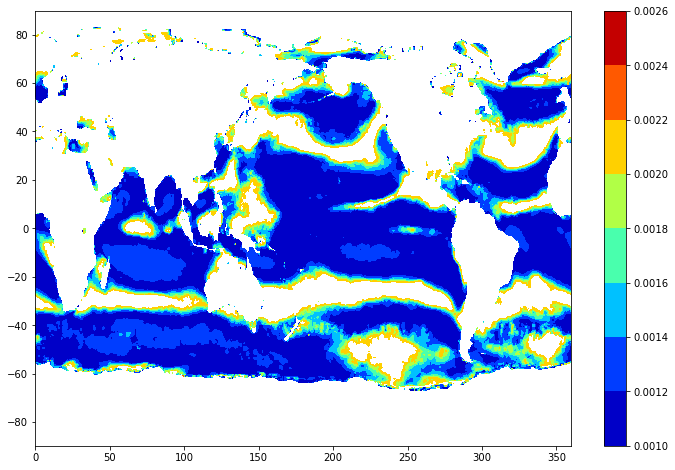

In [11]:
# again, make a quick plot
plt.figure(figsize=(12,8))
plt.contourf(lon,lat,CD,cmap = cm.jet)
plt.colorbar();

We can now calculate the wind stress:

In [12]:
rho = 1.3
taux = rho * CD * uwind * wspd
tauy = rho * CD * vwind * wspd
tau = np.sqrt(taux*taux+tauy*tauy)

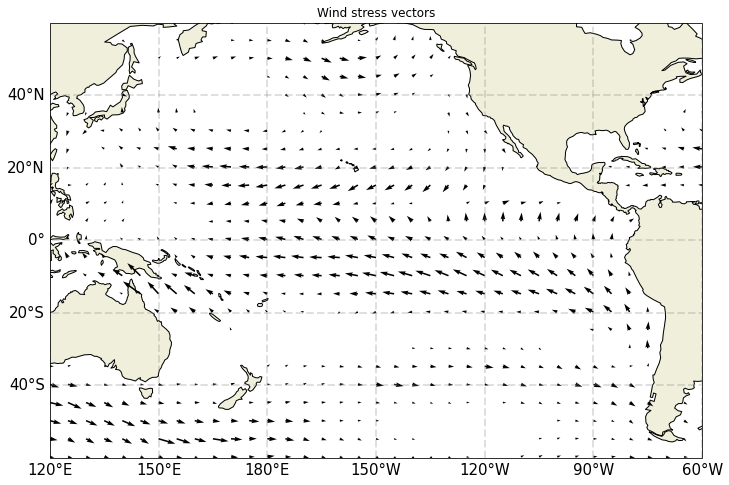

In [14]:
# now lets try make a plot
plt.figure(figsize=(12,8))

# use PlateCarree project and center on the Pacific
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAND)
ax.set_extent([120, 300, -60, 60], crs=ccrs.PlateCarree())

# add grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha = 0.25, linestyle='--')

# labels on bottom and left axes
gl.xlabels_top = False
gl.ylabels_right = False

# define the label style
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

# define exactly which ones to label
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150, -120, -90, -60])
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plot wind stress as vectors
#  Note here we have a lot of data, so we will subset to
#  make the plot look more readable
plt.quiver(lon[::20],lat[::20],taux[::20,::20],tauy[::20,::20],transform=ccrs.PlateCarree())

ax.set_title('Wind stress vectors');

## 3B. Compute Ekman transport

From the zonal and meridional components we can calculate the [Ekman transport](https://en.wikipedia.org/wiki/Ekman_transport) using the following relations:

$M_x = \frac{\tau_y}{f}$

$M_y = -\frac{\tau_x}{f}$

Where $M_x$ is the zonal Ekman transport, $M_y$ is the meridional Ekman transport, and $f$ the Coriolis parameter and depends on the latitude:

$f = 2\Omega\sin(\theta)$

Where $\Omega$ is the angular velocity of the Earth and $\theta$ is latitude.

In [15]:
# Define Coriolis parameter
Omega = 2*np.pi/(24*60*60)
f = 2*Omega*np.sin(lat*np.pi/180.)

# Compute transport; Note we have to increase the
#  dimensions of variable f to be 2 instead of 1,
#  thus numpy newaxis
Mx = tauy/f[:,np.newaxis]
My = -taux/f[:,np.newaxis]

Note that the *zonal* component of the Ekman transport is related to the *meridional* component of the wind stress, and vice-versa. First, let's have a look at the Coriolis parameter.

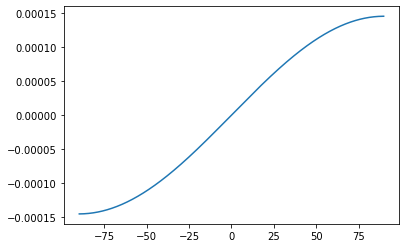

In [16]:
plt.plot(lat,f);

And now the Ekman transport

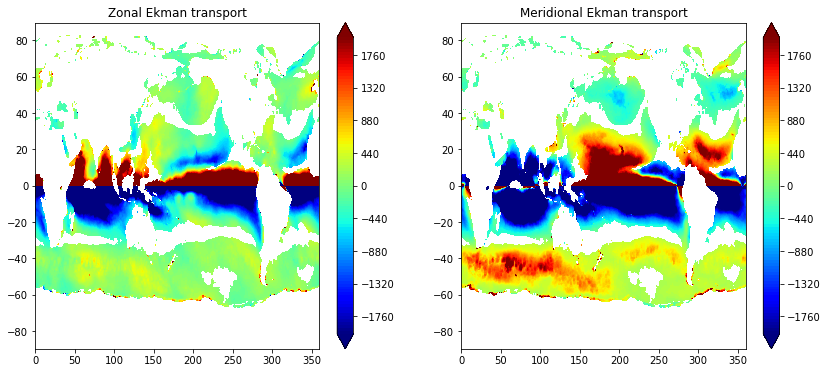

In [17]:
fig = plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
colors = plt.contourf(lon,lat,Mx,levels=np.linspace(-2000, 2000, 101), extend="both",cmap=cm.jet)
cb = plt.colorbar(colors)
ax1.set_label('kg s-1 m-1')
ax1.set_title('Zonal Ekman transport')

ax2 = plt.subplot(1,2,2)
colors = plt.contourf(lon,lat,My,levels=np.linspace(-2000, 2000, 101), extend="both",cmap=cm.jet)
cb = plt.colorbar(colors)
ax2.set_label('kg s-1 m-1')
ax2.set_title('Meridional Ekman transport');

/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/tmp/ipykernel_12193/3976188582.py:28: RuntimeWarning: invalid value encountered in sqrt
  color=np.sqrt(Mx*Mx+My*My),linewidth=2,density=5,cmap=cm.autumn)


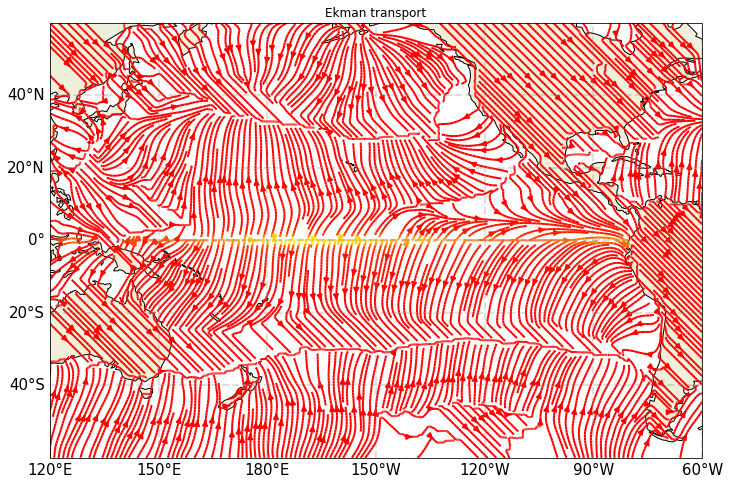

In [18]:
# try make a combined streamline plot
plt.figure(figsize=(12,8))

ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAND)
ax.set_extent([120, 300, -60, 60], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha = 0.25, linestyle='--')

# labels on bottom and left axes
gl.xlabels_top = False
gl.ylabels_right = False

# define the label style
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

# define exactly which ones to label
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150, -120, -90, -60])
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# try a streamline plot
plt.streamplot(lon,lat,Mx,My,transform=ccrs.PlateCarree(),
               color=np.sqrt(Mx*Mx+My*My),linewidth=2,density=5,cmap=cm.autumn)

ax.set_title('Ekman transport');

One problem with the calculation of Ekman transport is that it tends to infinity close to the equator. Let's mask a band of 5 degrees around the equator:

/opt/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/conda/envs/python/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:385: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


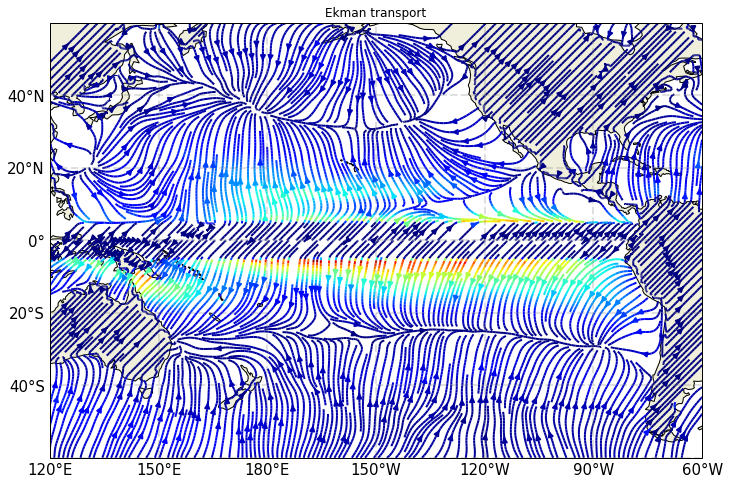

In [15]:
mask = np.abs(lat) < 5
lat2 = np.ma.masked_where(mask,lat)
Mx[mask] = np.ma.masked
My[mask] = np.ma.masked
Mmag = np.sqrt(Mx * Mx + My * My)

plt.figure(figsize=(12,8))
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
ax.add_feature(cf.COASTLINE)                 
ax.add_feature(cf.LAND)
ax.set_extent([120, 300, -60, 60], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha = 0.25, linestyle='--')

# labels on bottom and left axes
gl.xlabels_top = False
gl.ylabels_right = False

# define the label style
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

# now we define exactly which ones to label and spruce up the labels
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150, -120, -90, -60])
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.streamplot(lon,lat2,Mx,My,transform=ccrs.PlateCarree(),color=Mmag,density=5,
               linewidth=2,cmap=cm.jet)

ax.set_title('Ekman transport');

# 4. Satellite data: Ocean color

There are several satellites that have measured ocean (and land surface) color.  Most of the data can be found at the NASA/Goddard Space Flight Center (GSFC);

https://oceancolor.gsfc.nasa.gov/

In this exercise we will make a quick plot of ocean color from MODIS-Aqua to investigate upwelling off California.


In [1]:
# load array utils
import numpy as np

# load in plotting rountines
import matplotlib.pyplot as plt
from matplotlib import cm

# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netcdf for working with OPeNDAP files
# (can also use xarray)
import netCDF4 as nc

# import pandas for data handling and dates
import pandas as pd

# import datetime for date handling
import datetime as dt

In [2]:
# The data URL might be made more flexible by recognizing the syntax:
#  year/day of year
year = '2021'
doy = '105'
root_url = 'https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/'

In [3]:
URL = root_url + year + '/' + doy + '/A' + year + doy + '.L3m_DAY_CHL_chl_ocx_9km.nc'
file = nc.Dataset(URL)

In [4]:
# get all lat/lon/chl for a single day
lat = file.variables['lat'][:]
lon = file.variables['lon'][:]
chl = file.variables['chl_ocx'][:][:]

/opt/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


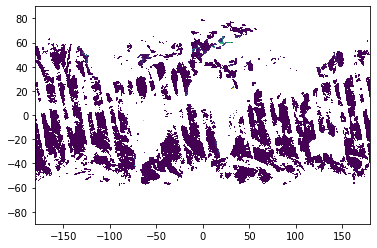

In [5]:
# quick-look at the data
plt.pcolormesh(lon,lat,chl)

In [11]:
# Subset for US West Coast

J = np.argwhere((lat>30)&(lat<40))
I = np.argwhere((lon>-125)&(lon<-115))

sub_lat = np.squeeze(lat[J])
sub_lon = np.squeeze(lon[I])
sub_chl = chl[int(J[0]):int(J[-1]+1),int(I[0]):int(I[-1])+1]

/opt/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/opt/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


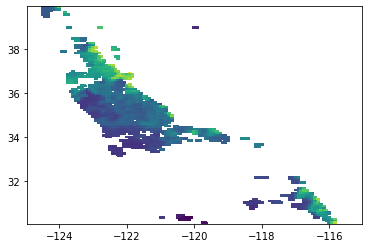

In [12]:
plt.pcolormesh(sub_lon,sub_lat,np.log(sub_chl))

/opt/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log


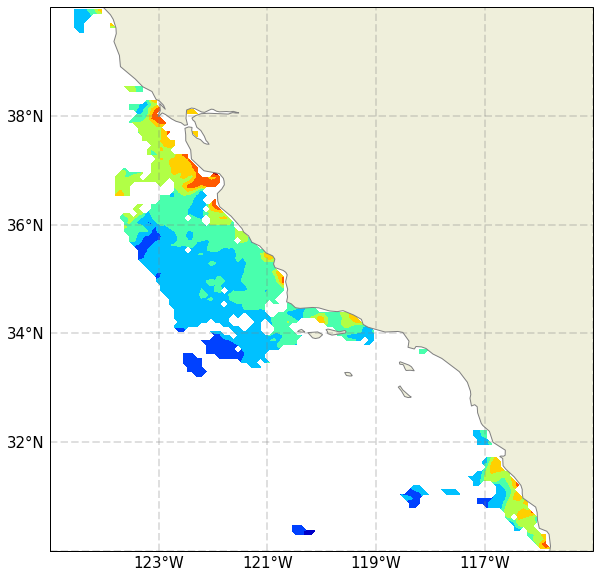

In [17]:
plt.figure(figsize=(10,10))

ax = plt.axes(projection = ccrs.PlateCarree())
#ax.add_feature(cf.COASTLINE)                 
#ax.add_feature(cf.LAND)
land_50m = cf.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cf.COLORS['land'])
ax.add_feature(land_50m, edgecolor='gray')

ax.set_extent([-125, -115, 30, 40], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha = 0.25, linestyle='--')

# labels on bottom and left axes
gl.xlabels_top = False
gl.ylabels_right = False

# define the label style
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

# now we define exactly which ones to label and spruce up the labels
gl.xlocator = mticker.FixedLocator([-125, -123, -121, -119, -117, -115])
gl.ylocator = mticker.FixedLocator([30, 32, 34, 36, 38, 40])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.contourf(sub_lon,sub_lat,np.log(sub_chl),cmap=cm.jet,transform=ccrs.PlateCarree())


# 5. OceanWatch data in Python

This tutorial will show the steps to grab data in ERDDAP from Python, how to work with NetCDF files in Python and how to make some maps and time-series od chlorophyll-a concentration around the main Hawaiian islands

## 5A. Downlading data from Python

Because ERDDAP includes RESTful services, you can download data listed on any ERDDAP platform from R using the URL structure. For example, the following page allows you to subset monthly Chlorophyll a data from the Aqua-MODIS sensor https://oceanwatch.pifsc.noaa.gov/erddap/griddap/OceanWatch_aqua_chla_monthly.html. Select your region and date range of interest, then select the '.nc' (NetCDF) file type and click on "Just Generate the URL".

![](erddap.png)

In this specific example, the URL we generated is :
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[(2018-01-01T12:00:00Z):1:(2018-12-01T12:00:00Z)][(17):1:(30)][(195):1:(210)]

In Python, run the following to download the data using the generated URL :


In [2]:
import urllib.request
url="https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[(2018-01-01T12:00:00Z):1:(2018-12-01T12:00:00Z)][(17):1:(30)][(195):1:(210)]"
urllib.request.urlretrieve(url, "sst.nc")

('sst.nc', <http.client.HTTPMessage at 0x2a195863be0>)

## 5B. Importing NetCDF4 data in Python

Now that we've downloaded the data locally, we can import it and extract our variables of interest.

The xarray package makes it very convenient to work with NetCDF files. Documentation is available here:
http://xarray.pydata.org/en/stable/why-xarray.html

In [3]:
import xarray as xr
import netCDF4 as nc

- Open the file and load it as an xarray dataset:

In [4]:
ds = xr.open_dataset('sst.nc',decode_cf=False)

- examine the data structure:

In [40]:
ds

<xarray.Dataset>
Dimensions:       (latitude: 261, longitude: 301, time: 12)
Coordinates:
  * time          (time) float64 1.515e+09 1.517e+09 ... 1.541e+09 1.544e+09
  * latitude      (latitude) float32 17.025 17.075 17.125 ... 29.975 30.025
  * longitude     (longitude) float32 195.025 195.075 ... 209.975 210.025
Data variables:
    analysed_sst  (time, latitude, longitude) float64 ...
Attributes:
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch program
    contributor_role:           Collecting source data and deriving products;...
    Conventions:                CF-1.6, ACDD-1.3, COARDS
    creator_email:              coralreefwatch@noaa.gov
    creator_institution:        NOAA/NESDIS/STAR Coral Reef Watch program
    creator_name:               NOAA Coral Reef Watch program
    creator_type:        

- examine which coordinates and variables are included in the dataset:

In [41]:
ds.coords

Coordinates:
  * time       (time) float64 1.515e+09 1.517e+09 ... 1.541e+09 1.544e+09
  * latitude   (latitude) float32 17.025 17.075 17.125 ... 29.925 29.975 30.025
  * longitude  (longitude) float32 195.025 195.075 195.125 ... 209.975 210.025

In [5]:
ds.data_vars

Data variables:
    analysed_sst  (time, latitude, longitude) float64 ...

- examine the structure of analysed_sst:

In [6]:
ds.analysed_sst.shape

(12, 261, 301)

Our dataset is a 3-D array with 261 rows corresponding to latitudes and 301 columns corresponding to longitudes,  for each of the 12 time steps.

- get the dates for each time step:

In [44]:
ds.time

<xarray.DataArray 'time' (time: 12)>
array([1.514808e+09, 1.517486e+09, 1.519906e+09, 1.522584e+09, 1.525176e+09,
       1.527854e+09, 1.530446e+09, 1.533125e+09, 1.535803e+09, 1.538395e+09,
       1.541074e+09, 1.543666e+09])
Coordinates:
  * time     (time) float64 1.515e+09 1.517e+09 1.52e+09 ... 1.541e+09 1.544e+09
Attributes:
    _CoordinateAxisType:    Time
    actual_range:           [1.5148080e+09 1.5436656e+09]
    axis:                   T
    coverage_content_type:  coordinate
    ioos_category:          Time
    long_name:              reference time of the sst field
    standard_name:          time
    time_origin:            01-JAN-1970 00:00:00
    units:                  seconds since 1970-01-01T00:00:00Z

In [45]:
dates=nc.num2date(ds.time,ds.time.units)
dates

array([datetime.datetime(2018, 1, 1, 12, 0),
       datetime.datetime(2018, 2, 1, 12, 0),
       datetime.datetime(2018, 3, 1, 12, 0),
       datetime.datetime(2018, 4, 1, 12, 0),
       datetime.datetime(2018, 5, 1, 12, 0),
       datetime.datetime(2018, 6, 1, 12, 0),
       datetime.datetime(2018, 7, 1, 12, 0),
       datetime.datetime(2018, 8, 1, 12, 0),
       datetime.datetime(2018, 9, 1, 12, 0),
       datetime.datetime(2018, 10, 1, 12, 0),
       datetime.datetime(2018, 11, 1, 12, 0),
       datetime.datetime(2018, 12, 1, 12, 0)], dtype=object)

## 5C. Working with the extracted data

### Creating a map for one time step

Let's create a map of SST for January 2018 (our first time step).

In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
np.warnings.filterwarnings('ignore')

- set some color breaks

In [49]:
np.nanmin(ds.analysed_sst)

17.922142857142862

In [50]:
np.nanmax(ds.analysed_sst)

28.390645161290323

In [ ]:
levs = np.arange(17.5, 28.5, 0.05)

- define a color palette

In [51]:
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]

- set color scale using the jet palette

In [ ]:
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

- plot the SST map

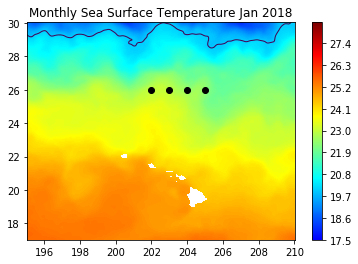

In [52]:
plt.contourf(ds.longitude, ds.latitude, ds.analysed_sst[0,:,:], levs,cmap=cm)
#plot the color scale
plt.colorbar()
#example of how to add points to the map
plt.scatter(range(202,206),np.repeat(26,4),c='black')
#example of how to add a contour line
plt.contour(ds.longitude, ds.latitude, ds.analysed_sst[0,:,:],levels=20,linewidths=1)
#plot title
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %Y'))
plt.show()

### Plotting a time series

Let's pick the following box : 18-23N, 200-206E. We are going to generate a time series of mean SST within that box.

- first, let subset our data:

In [53]:
lat_bnds, lon_bnds = [18, 23], [200, 206]
da=ds.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))

- let's plot the subset:

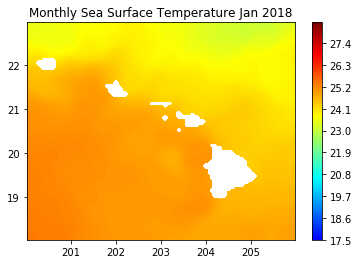

In [54]:
plt.contourf(da.longitude, da.latitude, da.analysed_sst[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %Y'))
plt.show()

- let's compute the monthly mean over the bounding region:

In [55]:
res=np.mean(da.analysed_sst,axis=(1,2))

- let's plot the time-series:

Text(0,0.5,'SST (ºC)')

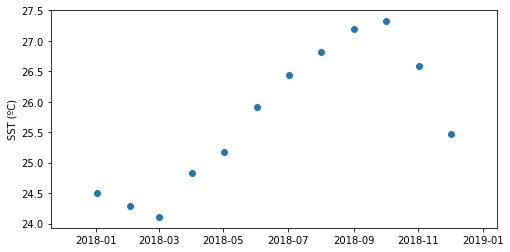

In [56]:
plt.figure(figsize=(8,4))
plt.scatter(dates,res)
plt.ylabel('SST (ºC)')

### Creating a map of average SST over a year

- let's compute the yearly mean for the region:

In [57]:
mean_sst=np.mean(ds.analysed_sst,axis=0)

In [58]:
mean_sst.shape

(261, 301)

- let's plot the map of the 2018 average SST in the region:

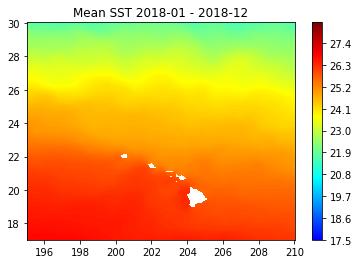

In [59]:
plt.contourf(ds.longitude, ds.latitude, mean_sst, levs,cmap=cm)
plt.colorbar()
plt.title("Mean SST " + dates[0].strftime('%Y-%m')+' - '+dates[11].strftime('%Y-%m'))
plt.show()

## 5D. Comparison of chlorophyll data from different sensors

Different ocean color sensors have been launched since 1997 to provide continuous global ocean color data. Unfortunately, because of differences in sensor design and calibration, chlorophyll-a concentration values don’t match during their periods of overlap, making it challenging to study long-term trends.

As an example, we are going to plot time-series of mean chlorophyll a concentration from various sensors from 1997 to 2019 to look at the periods of overlap. 
We are going to download data from Seawifs (1997-2010), MODIS (2002-2019) and VIIRS (2012-2019) and compare it to the ESA-CCI data (1997-2019) which combines all 3 sensors into a homogeneous time-series.

First, let's load all the packages needed:

In [1]:
import urllib.request 
import xarray as xr 
import netCDF4 as nc

import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap 
np.warnings.filterwarnings('ignore')

The OceanWatch website has a data catalog containing documentation and links to all the datasets available:
https://oceanwatch.pifsc.noaa.gov/doc.html

Navigate to the "Ocean Color" tab. From there you can access the different datasets using ERDDAP or THREDDS.

### Get monthly seawifs data, which starts in 1997

Go to ERDDAP to find the name of the dataset for monthly SeaWIFS data: sw_chla_monthly_2018_0

You should always examine the dataset in ERDDAP to check the date range, names of the variables and dataset ID, to make sure your griddap calls are correct: https://oceanwatch.pifsc.noaa.gov/erddap/griddap/sw_chla_monthly_2018_0.html

Notice also that for this dataset and others, the latitudes are ordered from North to South, which will affect the construction of the download URL. (ie. instead of selecting latitudes 0-40N, you need to request 40-0).

- let's download data for a box around the Hawaiian Islands:

In [2]:
url='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/sw_chla_monthly_2018_0.nc?chlor_a[(1997-10-16T12:00:00Z):1:(2010-10-16T12:00:00Z)][(25):1:(15)][(198):1:(208)]'

In [3]:
url

'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/sw_chla_monthly_2018_0.nc?chlor_a[(1997-10-16T12:00:00Z):1:(2010-10-16T12:00:00Z)][(25):1:(15)][(198):1:(208)]'

In [4]:
urllib.request.urlretrieve(url, "sw.nc")

('sw.nc', <http.client.HTTPMessage at 0x2324b3d4dd8>)

- let's use xarray to extract the data from the downloaded file:

In [5]:
sw_ds = xr.open_dataset('sw.nc',decode_cf=False)

In [6]:
sw_ds.data_vars

Data variables:
    chlor_a  (time, latitude, longitude) float32 ...

In [7]:
sw_ds.chlor_a.shape

(153, 121, 121)

The downloaded data contains only one variable: chlor_a.

- let's compute the monthly mean over the region and extract the dates corresponding to each month of data:

In [8]:
swAVG=np.mean(sw_ds.chlor_a,axis=(1,2))

swdates=nc.num2date(sw_ds.time,sw_ds.time.units) 

In [9]:
sw_ds.close()

### Get monthly MODIS data, that starts in 2002

In [10]:
url2='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_monthly_2018_0.nc?chlor_a[(2002-07-16T12:00:00Z):1:(2019-12-16T12:00:00Z)][(25):1:(15)][(198):1:(208)]'
urllib.request.urlretrieve(url2, "aq.nc")

('aq.nc', <http.client.HTTPMessage at 0x2324c3dd208>)

In [11]:
aq_ds = xr.open_dataset('aq.nc',decode_cf=False)
aqAVG=np.mean(aq_ds.chlor_a,axis=(1,2))

aqdates=nc.num2date(aq_ds.time,aq_ds.time.units) 

In [12]:
aq_ds.chlor_a.shape

(210, 241, 241)

In [13]:
aq_ds.close()

### Get monthly VIIRS data, which starts in 2012

In [14]:
url3='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/noaa_snpp_chla_monthly.nc?chlor_a[(2012-01-02T12:00:00Z):1:(2019-12-01T12:00:00Z)][(25):1:(15)][(198):1:(208)]'
urllib.request.urlretrieve(url3, "snpp.nc")

('snpp.nc', <http.client.HTTPMessage at 0x2324c3dd828>)

In [15]:
snpp_ds = xr.open_dataset('snpp.nc',decode_cf=False)
snppAVG=np.mean(snpp_ds.chlor_a,axis=(1,2))

snppdates=nc.num2date(snpp_ds.time,snpp_ds.time.units) 

In [16]:
snpp_ds.chlor_a.shape

(96, 267, 267)

In [17]:
snpp_ds.close()

### Get OC-CCI data (September 1997 to Dec 2019)

In [18]:
url4='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v4-2.nc?chlor_a[(1997-09-04):1:(2019-12-01T00:00:00Z)][(25):1:(15)][(198):1:(208)]'
urllib.request.urlretrieve(url4, "cci.nc")

('cci.nc', <http.client.HTTPMessage at 0x2324c3f3978>)

In [19]:
cci_ds = xr.open_dataset('cci.nc',decode_cf=False)
cciAVG=np.mean(cci_ds.chlor_a,axis=(1,2))
ccidates=nc.num2date(cci_ds.time,cci_ds.time.units) 

In [20]:
cci_ds.close()

### Plot the data

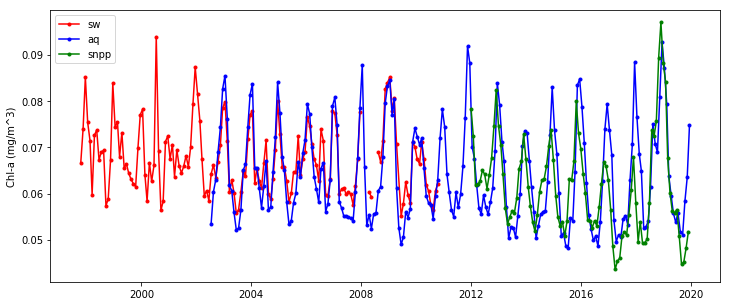

In [21]:
plt.figure(figsize=(12,5)) 
plt.plot(swdates,swAVG,label='sw',c='red',marker='.',linestyle='-')
plt.plot(aqdates,aqAVG,label='aq',c='blue',marker='.',linestyle='-')
plt.plot(snppdates,snppAVG,label='snpp',c='green',marker='.',linestyle='-')
plt.ylabel('Chl-a (mg/m^3)')
plt.legend()

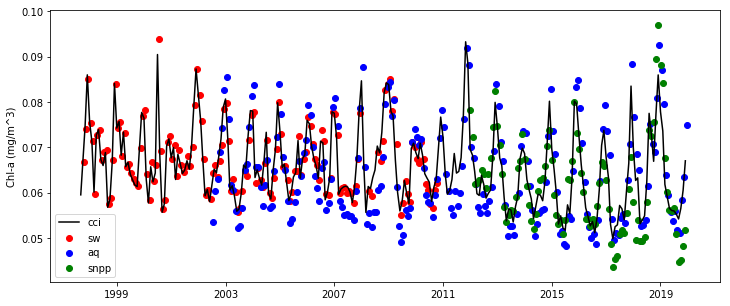

In [22]:
plt.figure(figsize=(12,5)) 
plt.plot(ccidates,cciAVG, label='cci',c='black')
plt.scatter(swdates,swAVG,label='sw',c='red')
plt.scatter(aqdates,aqAVG,label='aq',c='blue')
plt.scatter(snppdates,snppAVG,label='snpp',c='green')
plt.ylabel('Chl-a (mg/m^3)')
plt.legend()


## 5E.  Extract data within a shapefile using ERDDAP

This tutorial will teach you how to extract and display SST values for a particular time period or average SST over the whole time-series available within a shapefile.

The shapefile for the NOAA Marine National Monument and sanctuaries boundaries can be downloaded here: 
http://sanctuaries.noaa.gov/library/imast_gis.html. 
We are going to extract SST data for the Papahanaumokuakea Marine National Monument (PMNM) in Hawaii. However, because the Monument boundaries cross the dateline, the shapefile provided on the website is tricky to work with. We'll work with a cleaned up version, available here:
https://oceanwatch.pifsc.noaa.gov/files/PMNM_bounds.csv

### Load packages

In [20]:
import pandas as pd
import numpy as np
import time
import urllib.request 
import xarray as xr 
import netCDF4 as nc
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point, Polygon
import geopandas as gpd

np.warnings.filterwarnings('ignore')

### Load the Monument boundary

In [2]:
df=pd.read_csv('PMNM_bounds.csv')

Transform the boundary to a Polygon

In [3]:
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
poly = Polygon([(p.x, p.y)  for p in  geometry])

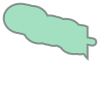

In [4]:
poly

### Data extraction

The example below extracts monthly 5km CoralTemp SST data within the monument boundary. 

- We are going to download data from ERDDAP for the smallest bounding box that contains our polygon

In [5]:
xcoord1 = (np.min(df.lon), np.max(df.lon))
ycoord1 = (np.min(df.lat), np.max(df.lat))

- let's select a date range:

In [6]:
tcoord = ("2019-01-15", "2019-12-15")

- and let's build our ERDDAP URL:

In [7]:
url='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[('+ tcoord[0] +'):1:('+ tcoord[1] +')][('+ str(ycoord1[0]) +'):1:('+ str(ycoord1[1]) +')][(' + str(xcoord1[0]) +'):1:('+ str(xcoord1[1]) +')]'

In [8]:
url

'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[(2019-01-15):1:(2019-12-15)][(19.2345832):1:(31.79786423)][(177.84422):1:(198.9827)]'

- now we can download the data:

In [9]:
urllib.request.urlretrieve(url, "sst.nc")

- and load it as an xarray dataset:

In [23]:
ds = xr.open_dataset('sst.nc',decode_cf=False)

In [10]:
ds.analysed_sst.shape

(12, 252, 424)

We now have data for a box around our polygon, for 12 monthly time steps (= 1 year).

### Masking the data outside the Monument boundary

The .within() function from the shapelypackage checks if a point is within a polygon. We are using it to create a mask which will take the value 1 within the polygon boundary, and NaN outside.

(This takes about 1min or less to run).

In [14]:
start_time=time.time()
mask=np.empty((len(ds.latitude.values),len(ds.longitude.values)))
mask[:]=np.NaN

for i in range(len(ds.latitude.values)):
    for j in range(len(ds.longitude.values)):
        p=Point(ds.longitude.values[j],ds.latitude.values[i],)     
        if int(p.within(poly))==1:
            mask[i,j]=int(p.within(poly))
            
end_time=time.time()
print("total time = %g mins" % ((end_time-start_time)/60.))

total time = 0.580524 mins


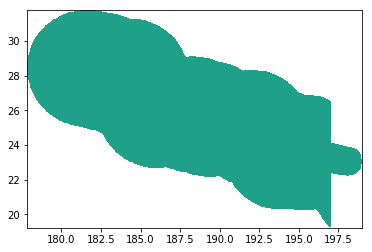

In [15]:
plt.contourf(ds.longitude,ds.latitude,mask)

We now multiply the SST data we downloaded by the mask values:

In [16]:
SST=ds.analysed_sst*mask

### Plotting the data

The extracted data contains several time steps (months) of sst data in the monument boundaries. Let's make a plot of the 4th time step for example.

- setting up the colormap

In [17]:
np.min(SST),np.max(SST)

(<xarray.DataArray 'analysed_sst' ()>
 array(16.863333), <xarray.DataArray 'analysed_sst' ()>
 array(28.78))

In [18]:
levs = np.arange(16, 29, 0.05)
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"] 
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

- loading data to plot the coastline. The file can be downloaded [here](https://oceanwatch.pifsc.noaa.gov/files/gz_2010_us_outline_20m.json), and was provided by https://eric.clst.org/tech/usgeojson/.
Download the file and save it to your computer.

In [21]:
# GeoJSON file downloaded from :
# https://eric.clst.org/tech/usgeojson/
country = gpd.read_file("gz_2010_us_outline_20m.json")
country.head()

TYPE R_STATEFP L_STATEFP  \
0  MEXICAN        48             
1  MEXICAN        35             
2  COASTAL        55             
3  COASTAL        55             
4  COASTAL        55             

                                            geometry  
0  LINESTRING (-97.14557 25.97113, -97.17263 25.9...  
1  LINESTRING (-106.52854 31.78391, -106.75055 31...  
2  LINESTRING (-86.89989 45.29518, -86.90490 45.2...  
3  LINESTRING (-90.46408 46.99464, -90.46546 47.0...  
4  LINESTRING (-87.59021 45.09526, -87.58715 45.0...

- plot:

Text(0.5,1,'SST - April 2019')

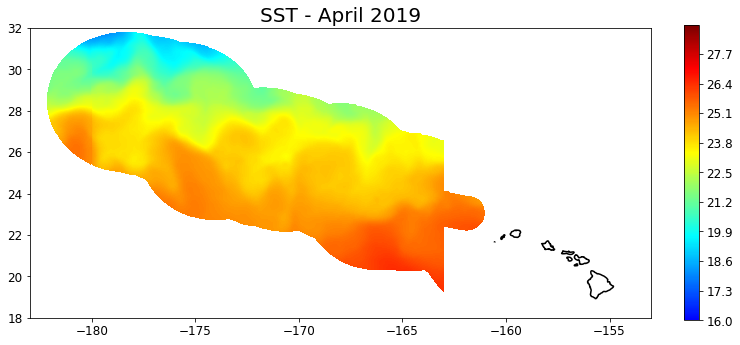

In [22]:
country.plot(figsize=(12,8),color='black')
plt.xlim(-183,-153)
plt.ylim(18,32)
cs=plt.contourf(ds.longitude-360,ds.latitude,SST[4,:,:],levs,cmap=cm)
cbar=plt.colorbar(fraction=0.022)
cbar.ax.tick_params(labelsize=12) 
cs.ax.tick_params(labelsize=12)
plt.title('SST - April 2019', fontsize=20)

## 5F. Example of loading and working which an ESRI shapefile instead of .csv file

In [10]:
from shapely.geometry import Point, Polygon

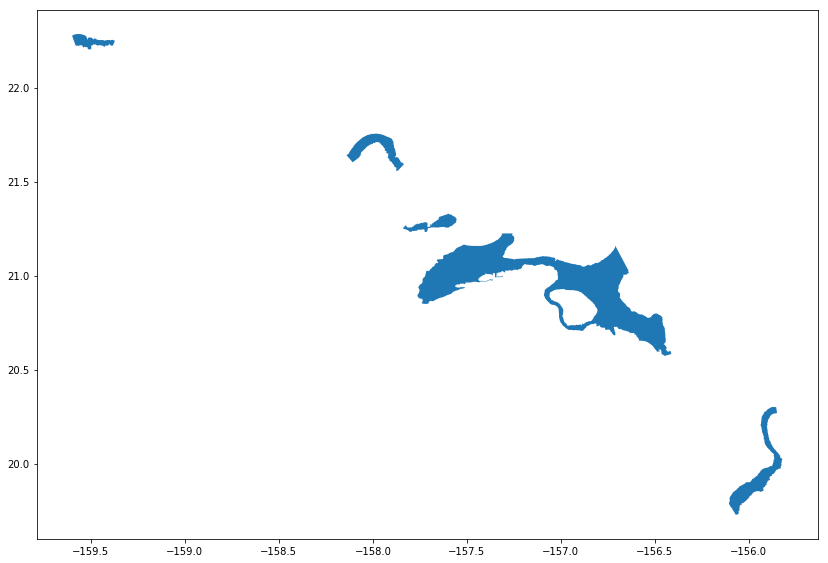

In [25]:
import geopandas as gpd
import descartes
from matplotlib import pyplot as plt 
fp='C:\VM_Shared_Directory\OceanWatch\indicators\Monument\pmnm_Expanded_py_Albers\PMNM_py_files\hihwnms_py.shp'
data = gpd.read_file(fp)

data.plot(figsize=(14, 10))
plt.show()

In [30]:
data

SANCTUARY   DATUM   AREA_NAME  POLY_ID    AREA_KM   AREA_NM    AREA_SM  \
0   HIHWNMS  NAD 83       LANAI        1  2696.5116  786.3028  1041.1248   
1   HIHWNMS  NAD 83       KAUAI        2   104.3560   30.4302    40.2919   
2   HIHWNMS  NAD 83  NORTH OAHU        3   230.6446   67.2560    89.0520   
3   HIHWNMS  NAD 83  SOUTH OAHU        4   120.5667   35.1572    46.5509   
4   HIHWNMS  NAD 83  BIG ISLAND        5   386.2967  112.6441   149.1494   

    AREA_ACRES  Shape_Leng  Shape_Le_1  Shape_Area  \
0  666344.3337    6.165034    6.165076    0.234101   
1   25787.7679    0.660569    0.660569    0.009149   
2   56995.3982    1.066711    1.066711    0.020138   
3   29793.6539    0.817195    0.817212    0.010496   
4   95459.1181    1.763711    1.763707    0.033281   

                                            geometry  
0  POLYGON ((-157.76263 20.89360, -157.76181 20.8...  
1  POLYGON ((-159.51848 22.25571, -159.51796 22.2...  
2  POLYGON ((-157.97863 21.75441, -157.97553 21.7...  
3  POLYGON ((-157.84098 21.25158, -157.82380 21.2...  
4  POLYGON ((-156.10583 19.78632, -156.10583 19.7...

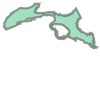

In [31]:
data.geometry[0]

In [32]:
p1=Point(-122.25,36.5)  #27.425 190.025
int(p1.within(data.geometry[0]))

0

## 5G. Extract data along a turtle track

This tutorial will teach you how to plot a loggerhead turtle track on a map.
That turtle was raised in captivity in Japan, then tagged and released on 05/04/2005 in the Central Pacific. It transmitted for over 3 years and went all the way to the Southern tip of Baja California!

The track data can be downloaded here:
https://oceanwatch.pifsc.noaa.gov/files/25317_05.dat

Then we'll extract SST and chlorophyll concentration at each location along the track, and plot the data.

### Load packages

In [222]:
import pandas as pd 
import numpy as np 
import urllib.request 
import xarray as xr 
import netCDF4 as nc 
import time
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap,BoundaryNorm,Normalize
from mpl_toolkits.basemap import Basemap
from datetime import date,datetime

np.warnings.filterwarnings('ignore')

- Let's load the track data:

In [ ]:
df=pd.read_csv('25317_05.dat')

In [289]:
df.head()

mean_lon   mean_lat  year  month  day
0  176.619433  32.678728  2005      5    4
1  176.783786  32.755451  2005      5    5
2  177.086095  32.870337  2005      5    6
3  177.523857  32.859396  2005      5    7
4  178.058145  32.674011  2005      5    8

### Let's plot the track on a map:

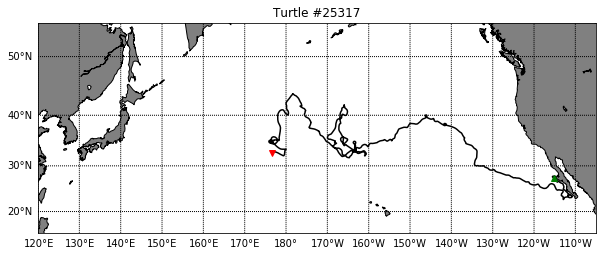

In [292]:
# Setup the bounding box for the zoom and bounds of the map
bbox=[120 ,255, 15, 55]
    
plt.figure(figsize=(10,10))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[2],urcrnrlat=bbox[3],\
            llcrnrlon=bbox[0],urcrnrlon=bbox[1],lat_ts=10,resolution='l')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='gray')

m.drawmeridians(np.arange(bbox[0], bbox[1], 10),labels=[0,0,0,1])
m.drawparallels(np.arange(bbox[2]+5, bbox[3], 10),labels=[1,0,0,0])

# build and plot coordinates onto map
x,y = m(list(df.mean_lon),list(df.mean_lat))
m.plot(x,y,color='k')
m.plot(x[0],y[0],marker='v',color='r')
m.plot(x[-1],y[-1],marker='^',color='g')
plt.title("Turtle #25317")
plt.show()

### Now let's extract data along the track

We are going to grab data from ERDDAP, so we need to set up the ERDDAP URLs using their datasets IDs and the name of the variables we are interested in.
Note that we are requesting the data as .csv

### Chlorophyll-a concentration

In [ ]:
MOD_d = "https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_1d_2018_0.csv?chlor_a"

Ideally, we would work with daily data since we have one location per day. But chlorophyll data is severely affected by clouds (i.e. lots of missing data), so you might need to use weekly or even monthly data to get sufficient non-missing data. 

Run all 3 of them, and plot a time-series of each to compare (as a separate exercise).

In [ ]:
MOD_w = "https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_8d_2018_0.csv?chlor_a" 
MOD_m = "https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_monthly_2018_0.csv?chlor_a"

In [ ]:
lon=df.mean_lon
lat=df.mean_lat

We need to format the dates in a way that ERDDAP understands, i.e. 2010-12-15

In [ ]:
dates=[]
for i in range(len(df.month)):
    dates.append(date(df.year[i],df.month[i],df.day[i]).strftime('%Y-%m-%d'))

In [287]:
dates[0]

'2005-05-04'

For each date and location, we'll extract a value of CHL or SST. To do this, we need to pass those parameters (which dataset, which date, which lon, and which lat) to ERDDAP by building the URL.

This can take a long time to run (about 15 mins), we are making 1200+ requests to a remote server. For the purpose of the exercise, you can just run the below code on the first 100 points of the turtle track.

In [ ]:
start_time=time.time()
col_names =  ["date","matched_lat","matched_lon","matched_chla"]
tot=pd.DataFrame(columns = col_names)

for i in range(len(dates)):
#for i in range(5):
    print(i,len(dates))
    #this is where the URL is built:
    url=MOD_m+"[("+str(dates[i])+"):1:("+str(dates[i])+")][("+str(lat[i])+"):1:("+str(lat[i])+")][("+str(lon[i])+"):1:("+str(lon[i])+")]"
    new=pd.read_csv(url,skiprows=1)
    new.columns=col_names
    tot=tot.append(new,ignore_index=True)

end_time=time.time()


In [293]:
print("total time = %g mins" % ((end_time-start_time)/60.))

total time = 14.4734 mins


In [185]:
tot.head()

date  matched_lat  matched_lon  matched_chla
0  2005-05-16T12:00:00Z    32.687500    176.60417      0.147827
1  2005-05-16T12:00:00Z    32.770832    176.77083      0.168947
2  2005-05-16T12:00:00Z    32.854168    177.10417      0.258081
3  2005-05-16T12:00:00Z    32.854168    177.52083      0.171364
4  2005-05-16T12:00:00Z    32.687500    178.06252      0.296886

We now have a value of monthly chlorophyll-a concentration for each location/date combination along the turtle track.

## On your own!

- Exercise 1:
Repeat the steps above with a different dataset.
For example, extract sea surface temperature data using the following dataset:
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0.html


- Exercise 2:
Go to an ERDDAP of your choice, find a dataset of interest, generate the URL, copy it and edit the script above to run a match up on that dataset.
To find other ERDDAP servers, you can use this search engine:
http://erddap.com/

Note! some ERDDAPs are slower than others, so this could take a lot longer. 
If it takes too long, adjust the "for" loop to request data for only the first 100 days of our track.

## Plot #2

Let's plot the track, color coded using values of monthly chlorophyll concentration.


- Let's create a color scale

In [187]:
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"] 

- Let's look at the range of log of monthly chlorophyll values:

In [190]:
np.min(np.log(tot.matched_chla)),np.max(np.log(tot.matched_chla))

(-2.8923874400191183, 2.136305926186285)

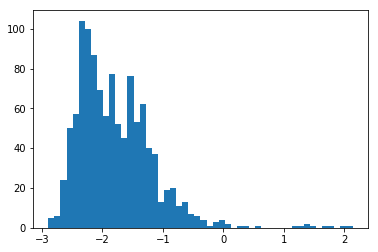

In [195]:
n, bins, patches=plt.hist(np.log(tot.matched_chla[~np.isnan(tot.matched_chla)]),50)
plt.show()

The range of log(chl-a) is -2.9 to 2.2 but most of the values are between -2.9 and 0. 

We use the log because the range of chlorophll values can be pretty big, with lots of very low values, and a few very high values.

In [263]:
levs = np.append(np.arange(-2.9,0,0.1),2.2)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

BoundaryNorm will force the colorbar to use the breaks in levs.

In [290]:
norm = BoundaryNorm(levs, len(levs))

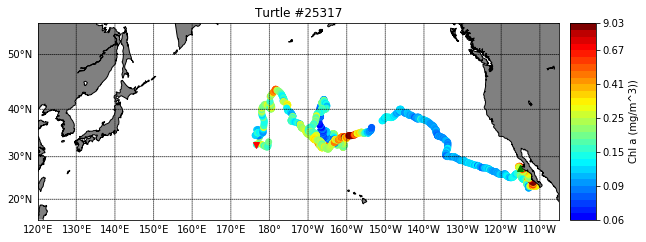

In [291]:
# Setup the bounding box for the zoom and bounds of the map
bbox=[120 ,255, 15, 55]
    
plt.figure(figsize=(10,10))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[2],urcrnrlat=bbox[3],\
            llcrnrlon=bbox[0],urcrnrlon=bbox[1],lat_ts=10,resolution='l')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='gray')

m.drawmeridians(np.arange(bbox[0], bbox[1], 10),labels=[0,0,0,1])
m.drawparallels(np.arange(bbox[2]+5, bbox[3], 10),labels=[1,0,0,0])

# build and plot coordinates onto map
x,y = m(list(df.mean_lon),list(df.mean_lat))
m.scatter(x,y,c=np.log(tot.matched_chla),cmap=cm,norm=norm)

m.plot(x[0],y[0],marker='v',color='r')
m.plot(x[-1],y[-1],marker='^',color='g')

#let's customize the color bar so the label reflect values of chl-a, not log(chl-a)
#we build levs2 to have the labels more spaced out than the values in levs
levs2=np.append(np.arange(-2.9,0,0.5),2.2)
cbar=m.colorbar(fraction=0.022,ticks=levs2, label='Chl a (mg/m^3))')
#and set the labels to be exp(levs2)
cbar.ax.set_yticklabels(np.around(np.exp(levs2),2))

plt.title("Turtle #25317")
plt.show()